In [75]:
# STEP 1: Upload and Load Dataset
import pandas as pd

df = pd.read_csv("/content/Fraud.csv",on_bad_lines='skip' )
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


Missing values:
 step              0
type              0
amount            0
nameOrig          1
oldbalanceOrg     1
newbalanceOrig    1
nameDest          1
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64


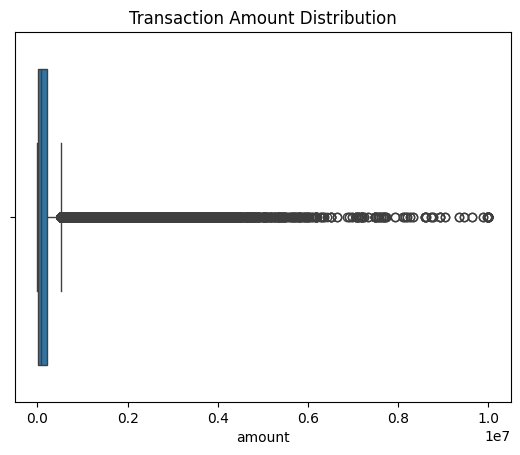

In [76]:
# STEP 2: Data Cleaning
# Check for missing values
print("Missing values:\n", df.isnull().sum())

df.fillna(0, inplace=True)

import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x=df['amount'])
plt.title('Transaction Amount Distribution')
plt.show()

df['amount'] = df['amount'].clip(upper=df['amount'].quantile(0.99))



In [77]:
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2655291 entries, 0 to 2655290
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         float64
 10  isFlaggedFraud  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 222.8+ MB


In [78]:
# STEP 3: Feature Engineering
# Create derived features
df['transaction_difference'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['isMerchant'] = df['nameDest'].str.startswith('M').astype(object)
df['balance_change_ratio'] = (df['newbalanceOrig'] - df['oldbalanceOrg']) / (df['oldbalanceOrg'] + 1e-5)

df = pd.get_dummies(df, columns=['type'], drop_first=True)

df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

print("Processed dataset shape:", df.shape)
df.head()



Processed dataset shape: (2655291, 15)


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,transaction_difference,isMerchant,balance_change_ratio,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0.0,0.0,9839.64,True,-0.057834,False,False,True,False
1,1,1864.28,21249.0,19384.72,0.0,0.0,0.0,0.0,1864.28,True,-0.087735,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,1.0,0.0,181.00,False,-1.000000,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,1.0,0.0,181.00,False,-1.000000,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0.0,0.0,11668.14,True,-0.280795,False,False,True,False


Fraud Distribution:
 isFraud
0.0    2652950
1.0       2341
Name: count, dtype: int64


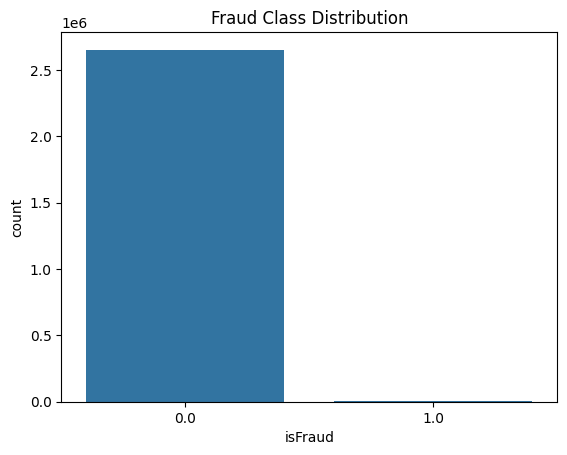

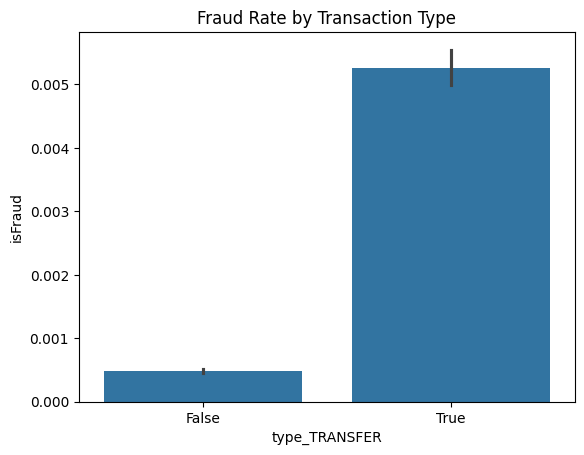

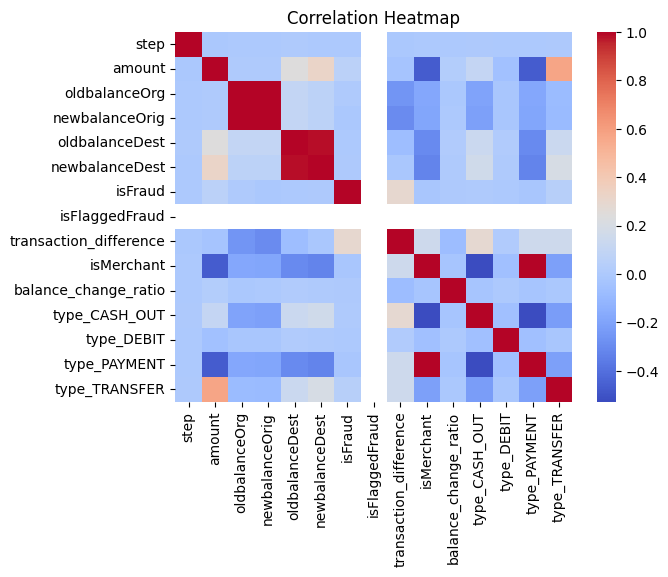

In [79]:
# STEP 4: Exploratory Data Analysis (EDA)
# Check class imbalance
print("Fraud Distribution:\n", df['isFraud'].value_counts())
sns.countplot(x='isFraud', data=df)
plt.title("Fraud Class Distribution")
plt.show()

sns.barplot(x='type_TRANSFER', y='isFraud', data=df)
plt.title('Fraud Rate by Transaction Type')
plt.show()

sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [80]:
# STEP 5: Splitting Data
from sklearn.model_selection import train_test_split

X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [81]:
# STEP 6: Model Training (Random Forest)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    795886
         1.0       0.99      0.73      0.84       702

    accuracy                           1.00    796588
   macro avg       0.99      0.87      0.92    796588
weighted avg       1.00      1.00      1.00    796588

ROC-AUC Score: 0.9953324850178796


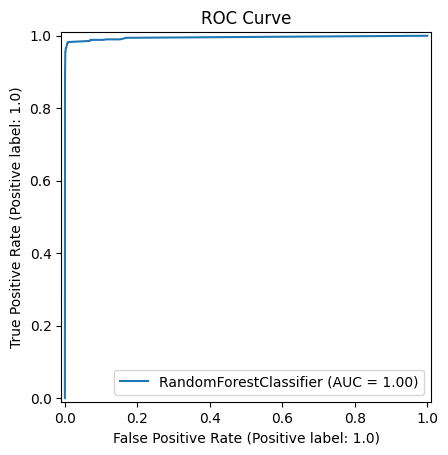

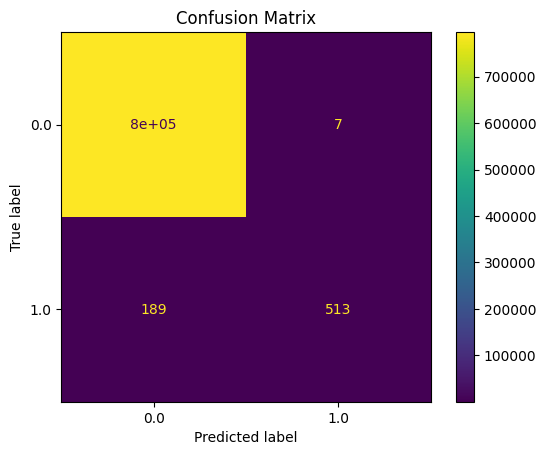

In [82]:
# STEP 7: Visualizing Model Performance
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

RocCurveDisplay.from_estimator(rf_model, X_test, y_test)
plt.title("ROC Curve")
plt.show()

ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()


Top 10 Important Features:
                    Feature  Importance
6   transaction_difference    0.306350
8     balance_change_ratio    0.172016
1                   amount    0.122657
2            oldbalanceOrg    0.112002
3           newbalanceOrig    0.074384
5           newbalanceDest    0.047086
12           type_TRANSFER    0.040201
4           oldbalanceDest    0.031390
7               isMerchant    0.027378
0                     step    0.023238


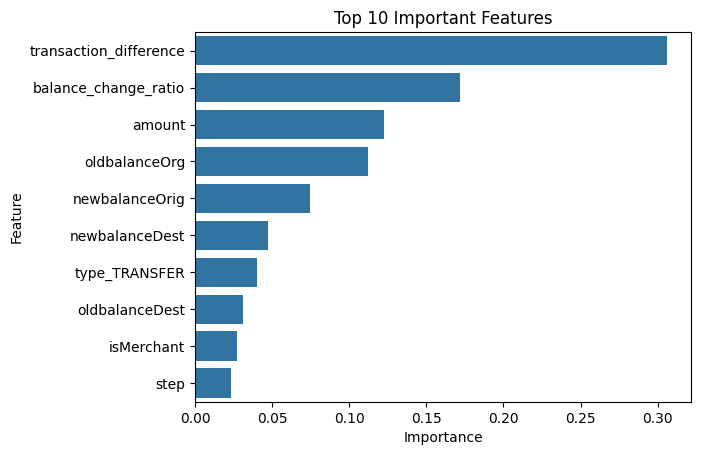

In [83]:
# STEP 8: Feature Importance
importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

print("Top 10 Important Features:\n", importance_df.head(10))

sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title("Top 10 Important Features")
plt.show()
